In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import numpy as np
from tqdm import tqdm
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x


In [24]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,1))
   f1, p1 = downsample_block(inputs, 64)
   f2, p2 = downsample_block(p1, 128)
   f3, p3 = downsample_block(p2, 256)
   f4, p4 = downsample_block(p3, 512)

   bottleneck = double_conv_block(p4, 1024)

   u6 = upsample_block(bottleneck, f4, 512)
   u7 = upsample_block(u6, f3, 256)
   u8 = upsample_block(u7, f2, 128)
   u9 = upsample_block(u8, f1, 64)

   outputs = layers.Conv2D(1, 1, padding="same", activation = "softmax")(u9)

   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model


In [25]:
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

In [40]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [41]:
def load_image_and_mask(image_file, mask_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=1)
    mask = tf.io.read_file(mask_file)
    mask = tf.image.decode_png(mask, channels=1)
    return image, mask

def load_image_train(image_file, mask_file):
    input_image, input_mask = load_image_and_mask(image_file, mask_file)
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

# Function to load and preprocess data for testing
def load_image_test(image_file, mask_file):
    input_image, input_mask = load_image_and_mask(image_file, mask_file)
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [42]:
train_images_dir = '/content/drive/MyDrive/train2/images'
train_masks_dir = '/content/drive/MyDrive/train2/masks'
test_images_dir = '/content/drive/MyDrive/test2/images'
test_masks_dir = '/content/drive/MyDrive/test2/masks'

In [46]:
train_image_files = sorted([os.path.join(train_images_dir, filename) for filename in os.listdir(train_images_dir)])
train_mask_files = sorted([os.path.join(train_masks_dir, filename) for filename in os.listdir(train_masks_dir)])
test_image_files = sorted([os.path.join(test_images_dir, filename) for filename in os.listdir(test_images_dir)])
test_mask_files = sorted([os.path.join(test_masks_dir, filename) for filename in os.listdir(test_masks_dir)])

# Create TensorFlow dataset for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_mask_files))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.take(200)  # Limit to first 200 samples for training

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_files, test_mask_files))
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.take(20)  # Limit to first 20 samples for testing

print("Number of training samples:", len(train_image_files))
print("Number of testing samples:", len(test_image_files))

Number of training samples: 96
Number of testing samples: 11


In [30]:
BATCH_SIZE = 12
BUFFER_SIZE = 100
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)


11


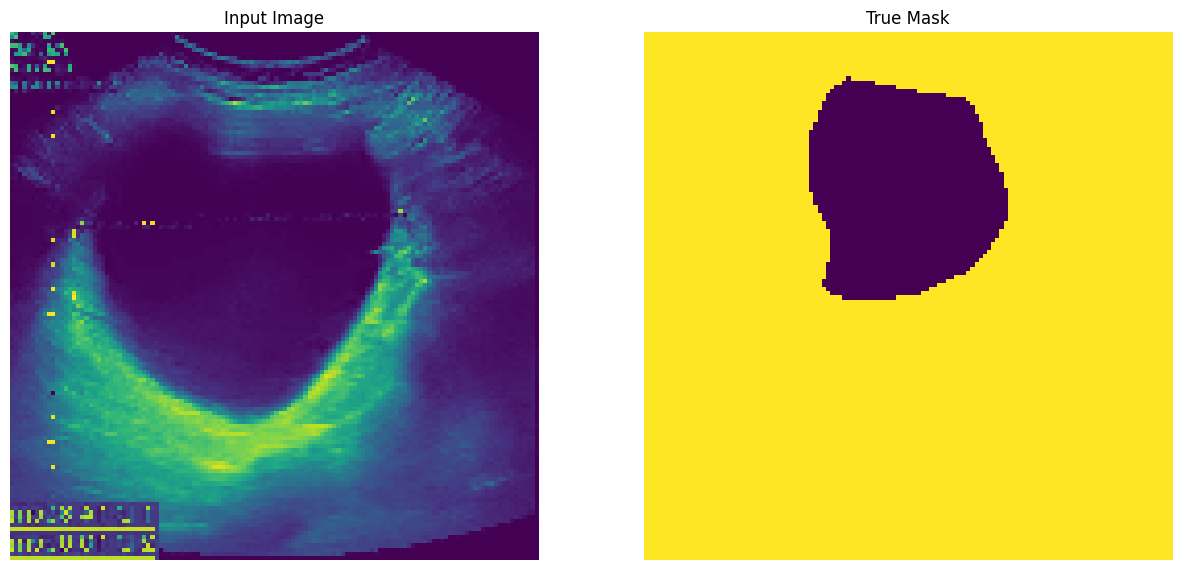

In [52]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
print(random_index)
display([sample_image, sample_mask])

In [39]:
NUM_EPOCHS = 20

# TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = 10

VAL_SUBSPLITS = 5
# TEST_LENTH = info.splits["test"].num_examples
# VALIDATION_STEPS = 20 // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 1

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-32-a4044a601a1c>", line 11, in <cell line: 11>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

Received a label value of 255 which is outside the valid range of [0, 1).  Label values: 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 255 255 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 255 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 255 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_13004]